In [18]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
import random
import numpy

torch.set_default_dtype(torch.float32)


class TBModel(nn.Module):
    def __init__(self, num_hid, num_points):
        super().__init__()
        # The input dimension is 6 for the 6 patches.
        self.mlp = nn.Sequential(
            nn.Linear(num_points + 1, num_hid),
            nn.ReLU(),  # Changed to ReLU
            nn.Linear(num_hid, num_hid),  # Added an extra hidden layer
            nn.ReLU(),  # Activation for the new hidden layer
            nn.Linear(num_hid, num_hid),  # Added an extra hidden layer
            nn.ReLU(),  # Activation for the new hidden layer
            nn.Linear(num_hid, num_hid),  # Added an extra hidden layer
            nn.ReLU(),  # Activation for the new hidden layer
            nn.Linear(num_hid, num_hid),  # Added an extra hidden layer
            nn.ReLU(),  # Activation for the new hidden layer
            # We now output 12 numbers, 6 for P_F and 6 for P_B
            nn.Linear(num_hid, 4),
        )
        self.num_points = num_points
        # log Z is just a single number
        self.logZ = nn.Parameter(torch.ones(1))

    def forward(self, x):
        position = x[-1]
        logits = self.mlp(x.to(torch.float32))
        # Slice the logits, and mask invalid actions (since we're predicting
        # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
        P_F = (
            logits[..., :2] * (position > 0) * (position < self.num_points)
            + (position == 0) * torch.tensor([-100, 100], dtype=torch.float32)
            + (position == self.num_points - 1)
            * torch.tensor([100, -100], dtype=torch.float32)
        )
        P_B = (
            logits[..., 2:] * (position > 0) * (position < self.num_points)
            + (position == 0) * torch.tensor([100, -100], dtype=torch.float32)
            + (position == self.num_points - 1)
            * torch.tensor([-100, 100], dtype=torch.float32)
        )
        return P_F, P_B

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def discretized_normal_pdf(mean, std_dev, num_points):
    """
    Returns a discretized normal PDF over the specified number of points.

    Parameters:
        mean (float): The mean of the normal distribution.
        std_dev (float): The standard deviation of the normal distribution.
        num_points (int): The number of points to discretize the PDF.

    Returns:
        x (numpy.ndarray): The x values (data points).
        pdf (numpy.ndarray): The corresponding PDF values.
    """
    # Define the range of x values
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, num_points)

    # Compute the PDF values
    pdf = norm.pdf(x, mean, std_dev)

    return pdf / pdf.sum()


def sample_reward_position(z):
    return np.random.choice(list(range(len(z))), 1, p=z.numpy() / z.numpy().sum())


def get_state(visited, pdf, position):
    new_pdf = (1 - visited) * pdf
    new_pdf = new_pdf / new_pdf.sum()
    position = torch.tensor([position], dtype=torch.float32)
    return torch.cat([new_pdf, position])

In [20]:
num_points = 15
pdf = discretized_normal_pdf(0, 1, num_points)
visited = torch.tensor(numpy.zeros(num_points), dtype=torch.float32)
pdf = torch.tensor(pdf, dtype=torch.float32)
position = 0.0
distance = 0

In [21]:
pdf = numpy.random.uniform(0, 1, 15)

In [22]:
pdf / pdf.sum()

array([0.02154866, 0.1135313 , 0.12759284, 0.13902377, 0.02106768,
       0.06409466, 0.09648008, 0.07192914, 0.05617602, 0.09347729,
       0.01478449, 0.03590907, 0.06128623, 0.06958283, 0.01351594])

In [50]:
num_points = 15
model = TBModel(100, num_points)

tb_losses = []
tb_sampled_decisions = []
minibatch_loss = 0
rewards = []
won = []
logZs = []

opt = torch.optim.Adam(model.parameters(), 1e-3)
update_freq = 10

# logZs = []
for episode in tqdm.tqdm(range(100_000)):
    failed = False
    # Each episode starts with an "empty state"
    state = []
    if episode % update_freq == 0:
        pdf = numpy.random.uniform(0, 1, num_points)
        pdf = torch.tensor(pdf, dtype=torch.float32)
        # pdf[numpy.argmax(numpy.random.uniform(0, 1, num_points))] = 1

    reward_position = sample_reward_position(pdf)[0]
    initial_position = num_points // 2

    path = []

    while reward_position == initial_position:
        reward_position = sample_reward_position(pdf)[0]

    position = initial_position

    visited = torch.tensor(numpy.zeros(num_points), dtype=torch.float32)

    state = get_state(visited, pdf, position)
    distance = 0

    P_F_s, P_B_s = model(state)
    play = True

    total_P_F = 0
    total_P_B = 0
    n = 2 * num_points

    while play:
        n -= 1

        try:
            # Here P_F is logits, so we want the Categorical to compute the softmax for us
            cat = Categorical(logits=P_F_s)
            action = cat.sample()
            total_P_F += cat.log_prob(action)

            position = position + 2 * action - 1
            distance += 1
            path.append(position)

            hasWon = position == reward_position

            if hasWon:
                won.append(True)
                reward = numpy.exp(
                    10 * ((num_points - 0.5 * distance) / num_points - 1)
                )
                play = False
                rewards.append(reward)

            elif position < 0 or position > num_points - 1 or n <= 0:
                won.append(False)
                reward = numpy.exp(
                    10 * ((num_points - 0.5 * distance) / num_points - 1)
                )
                rewards.append(reward)
                play = False

            visited[position] = 1
            state = get_state(visited, pdf, position)
            P_F_s, P_B_s = model(state)
            total_P_B += Categorical(logits=P_B_s).log_prob(action)
        except Exception as e:
            failed = True

    # We're done with the trajectory, let's compute its loss. Since the reward can
    # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
    if not failed:
        loss = (
            model.logZ
            + total_P_F
            - torch.log(torch.tensor(reward)).clip(-20)
            - total_P_B
        ).pow(2)
        minibatch_loss += loss

        # Add the face to the list, and if we are at an
        # update episode, take a gradient step.
        tb_sampled_decisions.append(path)
        if episode % update_freq == 0:
            tb_losses.append(minibatch_loss.item())
            minibatch_loss.backward()
            opt.step()
            opt.zero_grad()
            minibatch_loss = 0
            logZs.append(model.logZ.item())

    if episode % 10000 == 0:
        print("")
        print(numpy.mean(logZs[-100:]))
        print(numpy.mean(tb_losses[-100:]))
        print(numpy.mean(rewards[-100:]))
        print(numpy.mean(won[-100:]))

  0%|          | 4/100000 [00:00<2:41:43, 10.30it/s]


0.9990000128746033
125.29586029052734
4.5399929762484854e-05
0.0


 10%|█         | 10004/100000 [08:58<1:34:55, 15.80it/s]


0.2981869414448738
163.0612206363678
0.16012804772201686
0.95


 20%|██        | 20005/100000 [15:01<44:03, 30.26it/s]  


-0.3008254683017731
101.96992727279662
0.12772566707458893
0.94


 30%|███       | 30010/100000 [22:21<29:51, 39.08it/s]  


-0.8996004045009613
61.83904349327087
0.12108299582500763
0.95


 40%|████      | 40006/100000 [28:01<18:46, 53.28it/s]  


-1.360162377357483
48.13927801132202
0.1627142073077305
0.93


 41%|████      | 41007/100000 [28:26<40:54, 24.03it/s]


KeyboardInterrupt: 

In [51]:
pdf

tensor([0.4237, 0.6343, 0.8579, 0.4418, 0.3156, 0.5717, 0.7743, 0.6360, 0.0370,
        0.3247, 0.8172, 0.6869, 0.8710, 0.5343, 0.5467])

Text(0, 0.5, 'estimated Z')

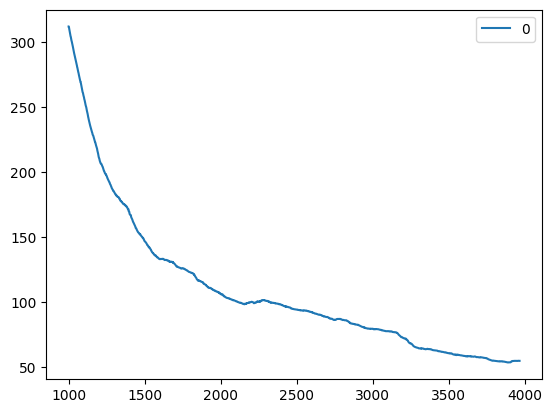

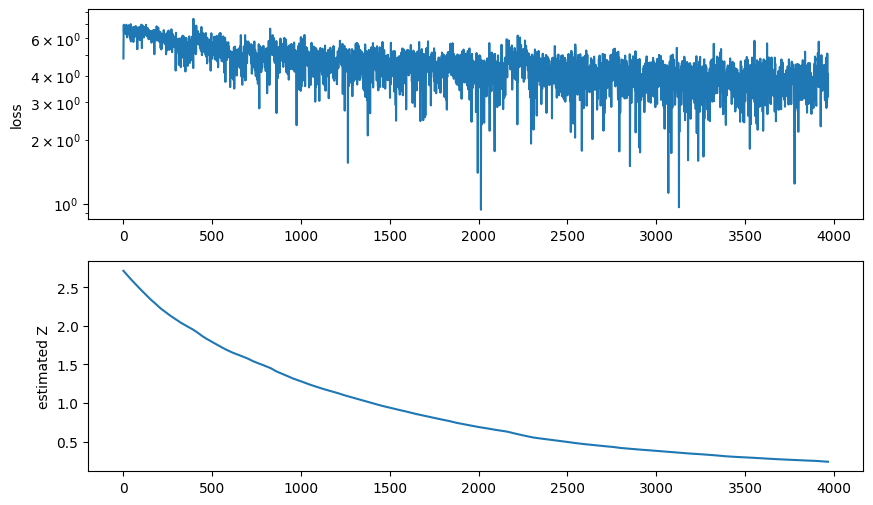

In [52]:
import matplotlib.pyplot as pp
import numpy as np
import pandas

loss_df = pandas.DataFrame(tb_losses)
loss_df.rolling(1000).mean().plot()
f, ax = pp.subplots(2, 1, figsize=(10, 6))
pp.sca(ax[0])
pp.plot(np.log(tb_losses))
pp.yscale("log")
pp.ylabel("loss")
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel("estimated Z")

<Axes: >

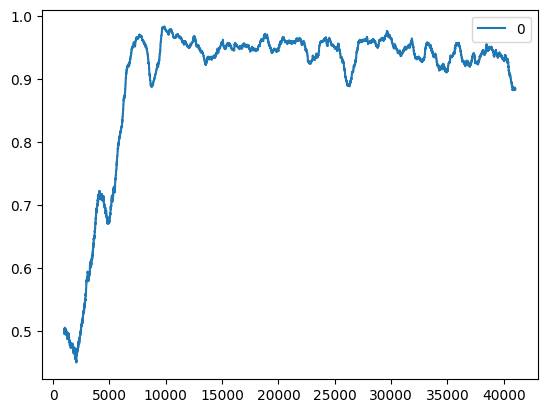

In [53]:
pandas.DataFrame(won).rolling(1000).mean().plot()

In [65]:
num_points = 15
pdf = discretized_normal_pdf(0, 1, num_points)
visited = torch.tensor(numpy.zeros(num_points), dtype=torch.float32)
state = get_state(visited, pdf, position)

In [56]:
sorted(rewards)

[4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,
 4.5399929762484854e-05,


In [62]:
mypdf = pdf.copy() * 0
mypdf[6] = 100000
probs = []
for position in range(num_points):
    state = get_state(visited, mypdf, position)
    z = model(state)[0]
    probs.append((torch.argmax(z), float(z[0])))

In [64]:
pdf

array([0.00190165, 0.00627515, 0.01723257, 0.03938291, 0.07490263,
       0.11855449, 0.15616027, 0.17118068, 0.15616027, 0.11855449,
       0.07490263, 0.03938291, 0.01723257, 0.00627515, 0.00190165])

In [66]:
def sample_path(position, pdf):
    path = []
    play = True
    visited = torch.tensor(numpy.zeros(num_points), dtype=torch.float32)
    n = 3 * len(pdf)
    while play and n > 0:
        n -= 1
        state = get_state(visited, pdf, position)

        try:
            P_F_s, P_B_s = model(state)
            # action = Categorical(logits=P_F_s).sample()
            action = torch.argmax(P_F_s)
        except:
            break
        position = position + 2 * action - 1
        path.append(position)
        visited[position] = 1

    return path

In [67]:
path = sample_path(7, pdf)

In [68]:
path

[tensor(6),
 tensor(5),
 tensor(6),
 tensor(7),
 tensor(8),
 tensor(9),
 tensor(10),
 tensor(11),
 tensor(10),
 tensor(9),
 tensor(8),
 tensor(7),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(3),
 tensor(2),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(5),
 tensor(6),
 tensor(7),
 tensor(8),
 tensor(9),
 tensor(10),
 tensor(11),
 tensor(12),
 tensor(13),
 tensor(14),
 tensor(13),
 tensor(12),
 tensor(11),
 tensor(10),
 tensor(9),
 tensor(8),
 tensor(7),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(3),
 tensor(2)]

In [52]:
state = get_state(visited, pdf, position)
pfs = model(state)[0]
cat = Categorical(logits=pfs)
log_prob = cat.log_prob(cat.sample())
action = cat.sample()

In [53]:
pfs

tensor([ 99.2182, -98.8506], grad_fn=<AddBackward0>)